# Operational Limits

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.special import xlogy

from validate import *

from scipy.stats import wilcoxon

plt.style.use('utils\plotstyle.mplstyle')

## Load Data

In [2]:
folder = 'UNIFESP+iCOPE'
model = 'NCNN'
path_experiments = f'experiments\\{folder}\\{model}'

if model == "VGGNB":
    filename_original = 'results_MCDP_0.5_30.pkl'
else:
    filename_original = 'results_MCDP_0.1_30.pkl'

filename_ = f'train_{filename_original}'

with open(os.path.join(path_experiments,filename_original), 'rb') as f:
    results_originais = pickle.load(f)

with open(os.path.join(path_experiments,filename_), 'rb') as f:
    results = pickle.load(f)

## Original Metrics

In [3]:
# Validation metrics
accuracy_original = np.zeros(len(results_originais.keys()))
f1_original = np.zeros(len(results_originais.keys()))
precision_original = np.zeros(len(results_originais.keys()))
sensitivity_original = np.zeros(len(results_originais.keys()))
specificity_original = np.zeros(len(results_originais.keys()))
auc_original = np.zeros(len(results_originais.keys()))

# Cria arrays com os resultados
for i, fold in enumerate(results_originais.keys()):
    metrics = validation_metrics(results_originais[fold]['preds'], results_originais[fold]['probs'], results_originais[fold]['labels'])
    accuracy_original[i] = metrics['Accuracy']
    f1_original[i] = metrics['F1 Score']
    precision_original[i] = metrics['Precision']
    sensitivity_original[i] = metrics['Sensitivity']
    specificity_original[i] = metrics['Specificity']
    auc_original[i] = metrics['AUC']

print(f"Acurácia       = {accuracy_original.mean():.4f} ± {accuracy_original.std():.2f}")
print(f"F1             = {f1_original.mean():.4f} ± {f1_original.std():.2f}")
print(f"Precisão       = {precision_original.mean():.4f} ± {precision_original.std():.2f}")
print(f"Sensibilidade  = {sensitivity_original.mean():.4f} ± {sensitivity_original.std():.2f}")
print(f"Especificidade = {specificity_original.mean():.4f} ± {specificity_original.std():.2f}")
print(f"AUC            = {auc_original.mean():.4f} ± {auc_original.std():.2f}")

Acurácia       = 0.8186 ± 0.05
F1             = 0.7839 ± 0.08
Precisão       = 0.8265 ± 0.07
Sensibilidade  = 0.7521 ± 0.11
Especificidade = 0.8613 ± 0.07
AUC            = 0.8924 ± 0.06


## Prepare DataFrame

In [4]:
list_probs = []
list_labels = []
list_preds = []
list_stds = []
list_corrects = []
list_folds = []

for i, fold in enumerate(results.keys()):
    
    labels = results[fold]['labels']
    probs = results[fold]['probs']
    preds = results[fold]['preds']
    stds = results[fold]['probs_uq'].std(axis=1)

    list_labels.extend(labels)
    list_probs.extend(probs)
    list_preds.extend(preds)
    list_stds.extend(stds)
    list_folds.extend([i] * len(labels))
    list_corrects.extend(preds == labels)


In [5]:
dataframe_calib = pd.DataFrame({'fold': list_folds, 'probs': list_probs, 'labels': list_labels, 'preds': list_preds, 'stds': list_stds, 'corrects': list_corrects})

In [6]:
dataframe_calib

,fold,probs,labels,preds,stds,corrects
0,0,0.995902,1.0,1.0,0.018362,True
1,0,0.980364,1.0,1.0,0.040053,True
2,0,0.283493,0.0,0.0,0.075883,True
3,0,0.262956,0.0,0.0,0.079440,True
4,0,0.240059,0.0,0.0,0.066507,True
...,...,...,...,...,...,...
98464,9,0.969082,1.0,1.0,0.032398,True
98465,9,0.978275,1.0,1.0,0.015482,True
98466,9,0.998865,1.0,1.0,0.004696,True
98467,9,0.999091,1.0,1.0,0.001245,True


In [7]:
list_probs = []
list_labels = []
list_preds = []
list_stds = []
list_corrects = []
list_folds = []


for i, fold in enumerate(results_originais.keys()):
    
    labels = results_originais[fold]['labels']
    probs = results_originais[fold]['probs']
    preds = results_originais[fold]['preds']
    stds = results_originais[fold]['probs_uq'].std(axis=1)

    list_labels.extend(labels)
    list_probs.extend(probs)
    list_preds.extend(preds)
    list_stds.extend(stds)
    list_folds.extend([i] * len(labels))
    list_corrects.extend(preds == labels)

In [8]:
dataframe_original = pd.DataFrame({'fold': list_folds, 'probs': list_probs, 'labels': list_labels, 'preds': list_preds, 'stds': list_stds, 'corrects': list_corrects})

## $\theta_{1}$ Calculation

In [9]:
preds_theta_1 = []
theta_1_list = []

for fold in range(10):

    fold_results = dataframe_calib[dataframe_calib['fold']==fold]

    fpr_probs, tpr_probs, thresholds_probs = roc_curve(fold_results['labels'], fold_results['probs'])
    idx_probs = np.argmax(tpr_probs - fpr_probs)

    theta_1 = thresholds_probs[idx_probs]
    
    fold_results_original = dataframe_original[dataframe_original['fold']==fold]

    preds = fold_results_original['probs'] >= theta_1
    preds = preds.astype('int')

    preds_theta_1.extend(preds)
    theta_1_list.extend([theta_1] * len(fold_results_original))

dataframe_original['theta_1'] = theta_1_list
dataframe_original['preds_theta_1'] = preds_theta_1

## $\theta_{2}$ Calculation

In [10]:
theta_2 = 0.9

In [11]:
bins = np.arange(0, 1.1, 0.1)  # From 0 to 1 with steps of 0.1

preds_theta_2 = []
theta_2_list = []

for fold in range(10):

    fold_results = dataframe_calib[dataframe_calib['fold']==fold]

    binids_correct = np.searchsorted(bins[1:-1], fold_results[fold_results['corrects']==True]['probs'])
    corrects = np.bincount(binids_correct, minlength=len(bins))[:-1]

    binids_incorrect = np.searchsorted(bins[1:-1], fold_results[fold_results['corrects']==False]['probs'])
    incorrects = np.bincount(binids_incorrect, minlength=len(bins))[:-1]

    precision = corrects / (corrects + incorrects)

    indexes_thresh = np.where(precision >= theta_2)[0]

    fold_results_original = dataframe_original[dataframe_original['fold']==fold]

    binids = np.searchsorted(bins[1:-1], fold_results_original['probs'])

    correcteness_probs = []

    for index in indexes_thresh:
        correcteness_probs.extend(list(np.where((binids == index))[0]))

    correcteness_probs = np.asarray(correcteness_probs)

    preds_theta_2_aux = np.empty(fold_results_original['probs'].shape)
    preds_theta_2_aux.fill(np.nan)
    preds_theta_2_aux[correcteness_probs] = fold_results_original['preds'].iloc[correcteness_probs]

    preds_theta_2.extend(preds_theta_2_aux)

    theta_2_list.extend([(bins[1:][indexes_thresh]).round(2)] * len(fold_results_original))

dataframe_original['preds_theta_2'] = preds_theta_2
dataframe_original['bins_theta_2'] = theta_2_list

## $\theta_{3}$ Calculation

In [12]:
mode = 'stds'

In [13]:
theta_3 = []

for fold in range(10):

    fold_results = dataframe_calib[dataframe_calib['fold']==fold]

    incorrects = fold_results['labels'] != fold_results['preds']

    fpr_probs, tpr_probs, thresholds_probs = roc_curve(incorrects, fold_results[mode])
    idx_probs = np.argmax(tpr_probs - fpr_probs)

    theta_3.append(thresholds_probs[idx_probs])

theta_3 = np.array(theta_3)

In [14]:
preds_theta_3 = []
theta_3_list = []

for fold in range(10):

    fold_results = dataframe_calib[dataframe_calib['fold']==fold]

    incorrects = fold_results['labels'] != fold_results['preds']

    fpr_probs, tpr_probs, thresholds_probs = roc_curve(incorrects, fold_results[mode])
    idx_probs = np.argmax(tpr_probs - fpr_probs)

    theta_3 = thresholds_probs[idx_probs]
    
    fold_results_original = dataframe_original[dataframe_original['fold']==fold]

    preds_certain_mask = fold_results_original[mode] <= theta_3

    preds_theta_3_aux = np.empty(fold_results_original['probs'].shape)
    preds_theta_3_aux.fill(np.nan)
    preds_theta_3_aux[preds_certain_mask] = fold_results_original['preds'][preds_certain_mask]

    preds_theta_3.extend(preds_theta_3_aux)
    theta_3_list.extend([theta_3] * len(fold_results_original))

dataframe_original['theta_3'] = theta_3_list
dataframe_original['preds_theta_3'] = preds_theta_3

In [15]:
dataframe_original

,fold,probs,labels,preds,stds,corrects,theta_1,preds_theta_1,preds_theta_2,bins_theta_2,theta_3,preds_theta_3
0,0,0.118455,0.0,0.0,0.083526,True,0.563725,0,0.0,"[0.1, 0.2, 1.0]",0.054174,NaN
1,0,0.167263,0.0,0.0,0.064061,True,0.563725,0,0.0,"[0.1, 0.2, 1.0]",0.054174,NaN
2,0,0.181865,0.0,0.0,0.063881,True,0.563725,0,0.0,"[0.1, 0.2, 1.0]",0.054174,NaN
3,0,0.039294,0.0,0.0,0.050901,True,0.563725,0,0.0,"[0.1, 0.2, 1.0]",0.054174,0.0
4,0,0.086721,0.0,0.0,0.047829,True,0.563725,0,0.0,"[0.1, 0.2, 1.0]",0.054174,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
516,9,0.293166,0.0,0.0,0.085530,True,0.447288,0,NaN,"[0.1, 0.9, 1.0]",0.058487,NaN
517,9,0.438311,0.0,0.0,0.098459,True,0.447288,0,NaN,"[0.1, 0.9, 1.0]",0.058487,NaN
518,9,0.883363,1.0,1.0,0.050356,True,0.447288,1,1.0,"[0.1, 0.9, 1.0]",0.058487,1.0
519,9,0.342238,1.0,0.0,0.107152,False,0.447288,0,NaN,"[0.1, 0.9, 1.0]",0.058487,NaN


In [16]:
print(f"{dataframe_original['theta_1'].unique().mean():.4f} +- {dataframe_original['theta_1'].unique().std():.4f}")

0.4445 +- 0.1169


In [17]:
unique_tuples = set(tuple(arr) for arr in dataframe_original['bins_theta_2'].values)

# Convert the unique tuples back to NumPy arrays
unique_arrays = np.array([np.array(tup) for tup in unique_tuples])

C:\Users\leonardo\AppData\Local\Temp\ipykernel_13976\486640710.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unique_arrays = np.array([np.array(tup) for tup in unique_tuples])


In [18]:
unique_arrays

array([array([0.1, 0.9, 1. ]), array([0.1, 0.8, 0.9, 1. ]),
       array([0.1, 0.2, 1. ]), array([0.1, 0.2, 0.9, 1. ])], dtype=object)

In [19]:
print(f"{dataframe_original['theta_3'].unique().mean():.4f} +- {dataframe_original['theta_3'].unique().std():.4f}")

0.0470 +- 0.0126


## Metrics

In [20]:
n_bins = 10
mode_metrics = 'quantile'

### Original Metrics

In [21]:
# Validation metrics
accuracy_original = np.zeros(len(results_originais.keys()))
f1_original = np.zeros(len(results_originais.keys()))
precision_original = np.zeros(len(results_originais.keys()))
sensitivity_original = np.zeros(len(results_originais.keys()))
specificity_original = np.zeros(len(results_originais.keys()))
auc_original = np.zeros(len(results_originais.keys()))

ece_original = np.zeros(len(results_originais.keys()))
mce_original = np.zeros(len(results_originais.keys()))
nll_original = np.zeros(len(results_originais.keys()))
brier_original = np.zeros(len(results_originais.keys()))

for fold in range(10):

    fold_results = dataframe_original[dataframe_original['fold']==fold]

    preds = fold_results['preds']
    probs = fold_results['probs']
    labels = fold_results['labels']

    metrics = validation_metrics(preds, probs, labels)
    accuracy_original[fold] = metrics['Accuracy']
    f1_original[fold] = metrics['F1 Score']
    precision_original[fold] = metrics['Precision']
    sensitivity_original[fold] = metrics['Sensitivity']
    specificity_original[fold] = metrics['Specificity']
    auc_original[fold] = metrics['AUC']

    metrics = calibration_metrics(probs, labels, n_bins=n_bins, mode=mode_metrics)
    ece_original[fold] = metrics['ECE']
    mce_original[fold] = metrics['MCE']
    nll_original[fold] = metrics['NLL']
    brier_original[fold] = metrics['Brier']

print(f"Acurácia       = {accuracy_original.mean():.4f} ± {accuracy_original.std():.2f}")
print(f"F1             = {f1_original.mean():.4f} ± {f1_original.std():.2f}")
print(f"Precisão       = {precision_original.mean():.4f} ± {precision_original.std():.2f}")
print(f"Sensibilidade  = {sensitivity_original.mean():.4f} ± {sensitivity_original.std():.2f}")
print(f"Especificidade = {specificity_original.mean():.4f} ± {specificity_original.std():.2f}")
print(f"AUC            = {auc_original.mean():.4f} ± {auc_original.std():.2f}")
print()
print(f"ECE    = {ece_original.mean():.4f} ± {ece_original.std():.2f}")
print(f"MCE    = {mce_original.mean():.4f} ± {mce_original.std():.2f}")
print(f"NLL    = {nll_original.mean():.4f} ± {nll_original.std():.2f}")
print(f"Brier  = {brier_original.mean():.4f} ± {brier_original.std():.2f}")


Acurácia       = 0.8186 ± 0.05
F1             = 0.7839 ± 0.08
Precisão       = 0.8265 ± 0.07
Sensibilidade  = 0.7521 ± 0.11
Especificidade = 0.8613 ± 0.07
AUC            = 0.8924 ± 0.06

ECE    = 0.1174 ± 0.03
MCE    = 0.2904 ± 0.09
NLL    = 0.3971 ± 0.09
Brier  = 0.1284 ± 0.03


### Metrics with $\theta_1$

In [22]:
# Validation metrics
accuracy_theta_1 = np.zeros(len(results_originais.keys()))
f1_theta_1 = np.zeros(len(results_originais.keys()))
precision_theta_1 = np.zeros(len(results_originais.keys()))
sensitivity_theta_1 = np.zeros(len(results_originais.keys()))
specificity_theta_1 = np.zeros(len(results_originais.keys()))
auc_theta_1 = np.zeros(len(results_originais.keys()))

ece_theta_1 = np.zeros(len(results_originais.keys()))
mce_theta_1 = np.zeros(len(results_originais.keys()))
nll_theta_1 = np.zeros(len(results_originais.keys()))
brier_theta_1 = np.zeros(len(results_originais.keys()))

for fold in range(10):

    fold_results = dataframe_original[dataframe_original['fold']==fold]

    preds = fold_results['preds_theta_1']
    probs = fold_results['probs']
    labels = fold_results['labels']

    metrics = validation_metrics(preds, probs, labels)
    accuracy_theta_1[fold] = metrics['Accuracy']
    f1_theta_1[fold] = metrics['F1 Score']
    precision_theta_1[fold] = metrics['Precision']
    sensitivity_theta_1[fold] = metrics['Sensitivity']
    specificity_theta_1[fold] = metrics['Specificity']
    auc_theta_1[fold] = metrics['AUC']

    metrics = calibration_metrics(probs, labels, n_bins=n_bins, mode=mode_metrics)
    ece_theta_1[fold] = metrics['ECE']
    mce_theta_1[fold] = metrics['MCE']
    nll_theta_1[fold] = metrics['NLL']
    brier_theta_1[fold] = metrics['Brier']

print(f"Acurácia       = {accuracy_theta_1.mean():.4f} ± {accuracy_theta_1.std():.2f}")
print(f"F1             = {f1_theta_1.mean():.4f} ± {f1_theta_1.std():.2f}")
print(f"Precisão       = {precision_theta_1.mean():.4f} ± {precision_theta_1.std():.2f}")
print(f"Sensibilidade  = {sensitivity_theta_1.mean():.4f} ± {sensitivity_theta_1.std():.2f}")
print(f"Especificidade = {specificity_theta_1.mean():.4f} ± {specificity_theta_1.std():.2f}")
print(f"AUC            = {auc_theta_1.mean():.4f} ± {auc_theta_1.std():.2f}")
print()
print(f"ECE    = {ece_theta_1.mean():.4f} ± {ece_theta_1.std():.2f}")
print(f"MCE    = {mce_theta_1.mean():.4f} ± {mce_theta_1.std():.2f}")
print(f"NLL    = {nll_theta_1.mean():.4f} ± {nll_theta_1.std():.2f}")
print(f"Brier  = {brier_theta_1.mean():.4f} ± {brier_theta_1.std():.2f}")


Acurácia       = 0.8242 ± 0.06
F1             = 0.7922 ± 0.10
Precisão       = 0.8261 ± 0.08
Sensibilidade  = 0.7831 ± 0.16
Especificidade = 0.8359 ± 0.12
AUC            = 0.8924 ± 0.06

ECE    = 0.1174 ± 0.03
MCE    = 0.2904 ± 0.09
NLL    = 0.3971 ± 0.09
Brier  = 0.1284 ± 0.03


In [23]:
s = ''
for x in [accuracy_theta_1,f1_theta_1,precision_theta_1,sensitivity_theta_1,specificity_theta_1,auc_theta_1,ece_theta_1,mce_theta_1,nll_theta_1,brier_theta_1]:
    for i in x[:-1]:
        s = s + str(i.round(4)).replace('.',',') + ';'
    s = s + str(x[-1].round(4)).replace('.',',') + '\n'
print(s)

0,8033;0,7143;0,8793;0,75;0,8431;0,8814;0,7937;0,7925;0,8611;0,9231
0,8182;0,7407;0,8679;0,5806;0,7647;0,8772;0,6667;0,8254;0,8718;0,9091
0,7941;0,6897;0,8846;0,75;0,8667;0,8929;0,9286;0,7222;0,85;0,8824
0,8438;0,8;0,8519;0,4737;0,6842;0,8621;0,52;0,963;0,8947;0,9375
0,7586;0,625;0,9032;0,9091;0,9375;0,9;0,9737;0,6154;0,8235;0,913
0,9019;0,8317;0,9259;0,7831;0,9079;0,9287;0,8095;0,9117;0,9505;0,9728
0,1287;0,1267;0,094;0,1738;0,0758;0,0885;0,1119;0,1383;0,1312;0,1049
0,2983;0,269;0,3541;0,3254;0,1794;0,2194;0,2014;0,5219;0,2956;0,2393
0,4088;0,5042;0,3658;0,5759;0,3539;0,3302;0,4888;0,3589;0,3075;0,2765
0,1347;0,1672;0,1182;0,195;0,1105;0,1001;0,1636;0,1171;0,0964;0,0811



In [24]:
metric_original = [accuracy_original,f1_original,precision_original,sensitivity_original,specificity_original,auc_original,ece_original,mce_original,nll_original,brier_original]
metric_new = [accuracy_theta_1,f1_theta_1,precision_theta_1,sensitivity_theta_1,specificity_theta_1,auc_theta_1,ece_theta_1,mce_theta_1,nll_theta_1,brier_theta_1]


for values_originais, values in zip(metric_original,metric_new):

    try:
        stat, p_value = wilcoxon(values_originais, values)
        print(str(round(p_value,3)).replace('.',','))
    except ValueError:
        print(f'####')

0,463
0,515
0,767
0,26
0,735
####
####
####
####
####


c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


### Metrics with $\theta_2$

In [25]:
# Validation metrics
accuracy_theta_2 = np.zeros(len(results_originais.keys()))
f1_theta_2 = np.zeros(len(results_originais.keys()))
precision_theta_2  = np.zeros(len(results_originais.keys()))
sensitivity_theta_2 = np.zeros(len(results_originais.keys()))
specificity_theta_2 = np.zeros(len(results_originais.keys()))
auc_theta_2 = np.zeros(len(results_originais.keys()))

ece_theta_2 = np.zeros(len(results_originais.keys()))
mce_theta_2 = np.zeros(len(results_originais.keys()))
nll_theta_2 = np.zeros(len(results_originais.keys()))
brier_theta_2 = np.zeros(len(results_originais.keys()))

removed_correct_data_theta_2 = np.zeros(len(results_originais.keys()))
removed_incorrect_data_theta_2 = np.zeros(len(results_originais.keys()))
remove_total_data_theta_2 = np.zeros(len(results_originais.keys()))

for fold in range(10):

    fold_results = dataframe_original[dataframe_original['fold']==fold]

    index_remove = fold_results['preds_theta_2'].isna()

    total_corrects = fold_results['corrects']

    removed_data = total_corrects[index_remove]

    #removed_correct_data_theta_2[fold] = 1 - (len(index_remove) - removed_data.sum()) / len(index_remove)
    #removed_incorrect_data_theta_2[fold] = 1 - (len(index_remove) - (~removed_data).sum()) / len(index_remove)

    removed_correct_data_theta_2[fold] = removed_data.sum() / total_corrects.sum()
    removed_incorrect_data_theta_2[fold] = (~removed_data).sum() / (~total_corrects).sum()
    remove_total_data_theta_2[fold] = index_remove.sum() / len(index_remove)

    preds = fold_results['preds_theta_2'][~index_remove]
    probs = fold_results['probs'][~index_remove]
    labels = fold_results['labels'][~index_remove]

    if len(preds) > 0:
        try:
            metrics = validation_metrics(preds, probs, labels)
            accuracy_theta_2[fold] = metrics['Accuracy']
            f1_theta_2[fold] = metrics['F1 Score']
            precision_theta_2[fold] = metrics['Precision']
            sensitivity_theta_2[fold] = metrics['Sensitivity']
            specificity_theta_2[fold] = metrics['Specificity']
            auc_theta_2[fold] = metrics['AUC']
        except ValueError:
            accuracy_theta_2[fold] = np.nan
            f1_theta_2[fold] = np.nan
            precision_theta_2[fold] = np.nan
            sensitivity_theta_2[fold] = np.nan
            specificity_theta_2[fold] = np.nan
            auc_theta_2[fold] = np.nan

        metrics = calibration_metrics(probs, labels, n_bins=n_bins, mode=mode_metrics)
        ece_theta_2[fold] = metrics['ECE']
        mce_theta_2[fold] = metrics['MCE']
        nll_theta_2[fold] = metrics['NLL']
        brier_theta_2[fold] = metrics['Brier']

    else:
        accuracy_theta_2[fold] = np.nan
        f1_theta_2[fold] = np.nan
        precision_theta_2[fold] = np.nan
        sensitivity_theta_2[fold] = np.nan
        specificity_theta_2[fold] = np.nan
        auc_theta_2[fold] = np.nan

        ece_theta_2[fold] = np.nan
        mce_theta_2[fold] = np.nan
        nll_theta_2[fold] = np.nan
        brier_theta_2[fold] = np.nan


accuracy_theta_2[np.isnan(accuracy_theta_2)] = np.nanmean(accuracy_theta_2)
f1_theta_2[np.isnan(f1_theta_2)] = np.nanmean(f1_theta_2)
precision_theta_2[np.isnan(precision_theta_2)] = np.nanmean(precision_theta_2)
sensitivity_theta_2[np.isnan(sensitivity_theta_2)] = np.nanmean(sensitivity_theta_2)
specificity_theta_2[np.isnan(specificity_theta_2)] = np.nanmean(specificity_theta_2)
auc_theta_2[np.isnan(auc_theta_2)] = np.nanmean(auc_theta_2)

ece_theta_2[np.isnan(ece_theta_2)] = np.nanmean(ece_theta_2)
mce_theta_2[np.isnan(mce_theta_2)] = np.nanmean(mce_theta_2)
nll_theta_2[np.isnan(nll_theta_2)] = np.nanmean(nll_theta_2)
brier_theta_2[np.isnan(brier_theta_2)] = np.nanmean(brier_theta_2)

print(f"Acurácia       = {accuracy_theta_2.mean():.4f} ± {accuracy_theta_2.std():.2f}")
print(f"F1             = {f1_theta_2.mean():.4f} ± {f1_theta_2.std():.2f}")
print(f"Precisão       = {precision_theta_2.mean():.4f} ± {precision_theta_2.std():.2f}")
print(f"Sensibilidade  = {sensitivity_theta_2.mean():.4f} ± {sensitivity_theta_2.std():.2f}")
print(f"Especificidade = {specificity_theta_2.mean():.4f} ± {specificity_theta_2.std():.2f}")
print(f"AUC            = {auc_theta_2.mean():.4f} ± {auc_theta_2.std():.2f}")
print()
print(f"ECE    = {ece_theta_2.mean():.4f} ± {ece_theta_2.std():.2f}")
print(f"MCE    = {mce_theta_2.mean():.4f} ± {mce_theta_2.std():.2f}")
print(f"NLL    = {nll_theta_2.mean():.4f} ± {nll_theta_2.std():.2f}")
print(f"Brier  = {brier_theta_2.mean():.4f} ± {brier_theta_2.std():.2f}")

Acurácia       = 0.9551 ± 0.06
F1             = 0.9523 ± 0.07
Precisão       = 0.9656 ± 0.05
Sensibilidade  = 0.9503 ± 0.11
Especificidade = 0.9355 ± 0.11
AUC            = 0.9724 ± 0.03

ECE    = 0.0862 ± 0.04
MCE    = 0.2031 ± 0.09
NLL    = 0.1617 ± 0.12
Brier  = 0.0386 ± 0.04


In [26]:
s = ''
for x in [accuracy_theta_2,f1_theta_2,precision_theta_2,sensitivity_theta_2,specificity_theta_2,auc_theta_2,ece_theta_2,mce_theta_2,nll_theta_2,brier_theta_2,removed_correct_data_theta_2,removed_incorrect_data_theta_2,remove_total_data_theta_2]:
    for i in x[:-1]:
        s = s + str(i.round(4)).replace('.',',') + ';'
    s = s + str(x[-1].round(4)).replace('.',',') + '\n'
print(s)

0,9677;0,8333;1,0;0,9551;1,0;0,9459;0,8485;1,0;1,0;1,0
0,9677;0,8824;1,0;0,9523;1,0;0,9583;0,7619;1,0;1,0;1,0
0,9375;0,8333;1,0;0,9656;1,0;0,92;1,0;1,0;1,0;1,0
1,0;0,9375;1,0;0,9503;1,0;1,0;0,6154;1,0;1,0;1,0
0,9375;0,625;1,0;0,9355;1,0;0,8571;1,0;1,0;1,0;1,0
0,9792;0,9141;1,0;0,9724;1,0;0,9472;0,9115;1,0;1,0;1,0
0,0789;0,1413;0,0355;0,1535;0,0821;0,097;0,1115;0,0502;0,0582;0,0537
0,2786;0,4027;0,0932;0,1536;0,1958;0,1932;0,2907;0,1252;0,1516;0,1463
0,1597;0,3683;0,041;0,1666;0,1052;0,2038;0,3753;0,0589;0,0736;0,0644
0,0352;0,1183;0,0024;0,0235;0,0139;0,0541;0,12;0,0048;0,0073;0,0064
0,3878;0,4595;0,5417;0,9487;0,4091;0,3269;0,4167;0,4884;0,2581;0,4412
0,9167;0,6667;1,0;1,0;1,0;0,7143;0,6667;1,0;1,0;1,0
0,4918;0,5102;0,6207;0,9615;0,4902;0,3729;0,4762;0,5849;0,3611;0,5128



In [27]:
metric_original = [accuracy_original,f1_original,precision_original,sensitivity_original,specificity_original,auc_original,ece_original,mce_original,nll_original,brier_original]
metric_new = [accuracy_theta_2,f1_theta_2,precision_theta_2,sensitivity_theta_2,specificity_theta_2,auc_theta_2,ece_theta_2,mce_theta_2,nll_theta_2,brier_theta_2]


for values_originais, values in zip(metric_original,metric_new):

    try:
        stat, p_value = wilcoxon(values_originais, values)
        print(str(round(p_value,3)).replace('.',','))
    except ValueError:
        print(f'####')

0,002
0,002
0,004
0,002
0,105
0,002
0,064
0,105
0,002
0,002


### Metrics $\theta_3$

In [28]:
# Validation metrics
accuracy_theta_3 = np.zeros(len(results_originais.keys()))
f1_theta_3 = np.zeros(len(results_originais.keys()))
precision_theta_3  = np.zeros(len(results_originais.keys()))
sensitivity_theta_3 = np.zeros(len(results_originais.keys()))
specificity_theta_3 = np.zeros(len(results_originais.keys()))
auc_theta_3 = np.zeros(len(results_originais.keys()))

ece_theta_3 = np.zeros(len(results_originais.keys()))
mce_theta_3 = np.zeros(len(results_originais.keys()))
nll_theta_3 = np.zeros(len(results_originais.keys()))
brier_theta_3 = np.zeros(len(results_originais.keys()))

removed_correct_data_theta_3 = np.zeros(len(results_originais.keys()))
removed_incorrect_data_theta_3 = np.zeros(len(results_originais.keys()))
removed_total_data_theta_3 = np.zeros(len(results_originais.keys()))

for fold in range(10):

    fold_results = dataframe_original[dataframe_original['fold']==fold]

    index_remove = fold_results['preds_theta_3'].isna()

    total_corrects = fold_results['corrects']

    removed_data = total_corrects[index_remove]

    removed_correct_data_theta_3[fold] = removed_data.sum() / total_corrects.sum()
    removed_incorrect_data_theta_3[fold] = (~removed_data).sum() / (~total_corrects).sum()
    removed_total_data_theta_3[fold] = index_remove.sum() / len(index_remove)


    preds = fold_results['preds_theta_3'][~index_remove]
    probs = fold_results['probs'][~index_remove]
    labels = fold_results['labels'][~index_remove]

    if len(preds) > 0:
        try:
            metrics = validation_metrics(preds, probs, labels)
            accuracy_theta_3[fold] = metrics['Accuracy']
            f1_theta_3[fold] = metrics['F1 Score']
            precision_theta_3[fold] = metrics['Precision']
            sensitivity_theta_3[fold] = metrics['Sensitivity']
            specificity_theta_3[fold] = metrics['Specificity']
            auc_theta_3[fold] = metrics['AUC']
        except ValueError:
            accuracy_theta_3[fold] = np.nan
            f1_theta_3[fold] = np.nan
            precision_theta_3[fold] = np.nan
            sensitivity_theta_3[fold] = np.nan
            specificity_theta_3[fold] = np.nan
            auc_theta_3[fold] = np.nan

        metrics = calibration_metrics(probs, labels, n_bins=n_bins, mode=mode_metrics)
        ece_theta_3[fold] = metrics['ECE']
        mce_theta_3[fold] = metrics['MCE']
        nll_theta_3[fold] = metrics['NLL']
        brier_theta_3[fold] = metrics['Brier']

    else:
        accuracy_theta_3[fold] = np.nan
        f1_theta_3[fold] = np.nan
        precision_theta_3[fold] = np.nan
        sensitivity_theta_3[fold] = np.nan
        specificity_theta_3[fold] = np.nan
        auc_theta_3[fold] = np.nan

        ece_theta_3[fold] = np.nan
        mce_theta_3[fold] = np.nan
        nll_theta_3[fold] = np.nan
        brier_theta_3[fold] = np.nan


accuracy_theta_3[np.isnan(accuracy_theta_3)] = np.nanmean(accuracy_theta_3)
f1_theta_3[np.isnan(f1_theta_3)] = np.nanmean(f1_theta_3)
precision_theta_3[np.isnan(precision_theta_3)] = np.nanmean(precision_theta_3)
sensitivity_theta_3[np.isnan(sensitivity_theta_3)] = np.nanmean(sensitivity_theta_3)
specificity_theta_3[np.isnan(specificity_theta_3)] = np.nanmean(specificity_theta_3)
auc_theta_3[np.isnan(auc_theta_3)] = np.nanmean(auc_theta_3)

ece_theta_3[np.isnan(ece_theta_3)] = np.nanmean(ece_theta_3)
mce_theta_3[np.isnan(mce_theta_3)] = np.nanmean(mce_theta_3)
nll_theta_3[np.isnan(nll_theta_3)] = np.nanmean(nll_theta_3)
brier_theta_3[np.isnan(brier_theta_3)] = np.nanmean(brier_theta_3)

print(f"Acurácia       = {accuracy_theta_3.mean():.4f} ± {accuracy_theta_3.std():.2f}")
print(f"F1             = {f1_theta_3.mean():.4f} ± {f1_theta_3.std():.2f}")
print(f"Precisão       = {precision_theta_3.mean():.4f} ± {precision_theta_3.std():.2f}")
print(f"Sensibilidade  = {sensitivity_theta_3.mean():.4f} ± {sensitivity_theta_3.std():.2f}")
print(f"Especificidade = {specificity_theta_3.mean():.4f} ± {specificity_theta_3.std():.2f}")
print(f"AUC            = {auc_theta_3.mean():.4f} ± {auc_theta_3.std():.2f}")
print()
print(f"ECE    = {ece_theta_3.mean():.4f} ± {ece_theta_3.std():.2f}")
print(f"MCE    = {mce_theta_3.mean():.4f} ± {mce_theta_3.std():.2f}")
print(f"NLL    = {nll_theta_3.mean():.4f} ± {nll_theta_3.std():.2f}")
print(f"Brier  = {brier_theta_3.mean():.4f} ± {brier_theta_3.std():.2f}")

Acurácia       = 0.9289 ± 0.06
F1             = 0.9244 ± 0.06
Precisão       = 0.9491 ± 0.06
Sensibilidade  = 0.9130 ± 0.11
Especificidade = 0.9349 ± 0.12
AUC            = 0.9703 ± 0.04

ECE    = 0.1495 ± 0.21
MCE    = 0.3270 ± 0.25
NLL    = 0.3155 ± 0.41
Brier  = 0.1077 ± 0.17


c:\Users\leonardo\Desktop\Mestrado\validate.py:40: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity = tp / (tp + fn)  # also called recall in machine learning


In [29]:
s = ''
for x in [accuracy_theta_3,f1_theta_3,precision_theta_3,sensitivity_theta_3,specificity_theta_3,auc_theta_3,ece_theta_3,mce_theta_3,nll_theta_3,brier_theta_3,removed_correct_data_theta_3,removed_incorrect_data_theta_3,removed_total_data_theta_3]:
    for i in x[:-1]:
        s = s + str(i.round(4)).replace('.',',') + ';'
    s = s + str(x[-1].round(4)).replace('.',',') + '\n'
print(s)

0,871;0,7917;0,9259;0,9289;1,0;0,907;0,92;0,9444;1,0;1,0
0,913;0,8;0,9;0,9244;1,0;0,8947;0,8889;0,9231;1,0;1,0
0,84;1,0;0,9;0,9491;1,0;0,9444;1,0;0,8571;1,0;1,0
1,0;0,6667;0,9;0,913;1,0;0,85;0,8;1,0;1,0;1,0
0,6;1,0;0,9412;0,9349;1,0;0,9565;1,0;0,9167;1,0;1,0
0,9238;0,8889;0,9882;0,9703;1,0;0,9587;0,9733;1,0;1,0;1,0
0,1157;0,1924;0,0627;0,7739;0,022;0,06;0,0828;0,1022;0,0454;0,0382
0,3231;0,5566;0,1679;0,7739;0,0369;0,1163;0,3244;0,7094;0,1451;0,1166
0,3181;0,5007;0,1341;1,4868;0,0223;0,2531;0,1993;0,1359;0,0471;0,0572
0,0976;0,1654;0,0347;0,5989;0,0006;0,0744;0,0615;0,0358;0,0032;0,005
0,449;0,4865;0,4792;1,0;0,8864;0,25;0,5208;0,6047;0,5161;0,4706
0,6667;0,5833;0,8;0,9231;1,0;0,4286;0,8667;0,9;1,0;1,0
0,4918;0,5102;0,5345;0,9808;0,902;0,2712;0,6032;0,6604;0,5833;0,5385



In [30]:
metric_original = [accuracy_original,f1_original,precision_original,sensitivity_original,specificity_original,auc_original,ece_original,mce_original,nll_original,brier_original]
metric_new = [accuracy_theta_3,f1_theta_3,precision_theta_3,sensitivity_theta_3,specificity_theta_3,auc_theta_3,ece_theta_3,mce_theta_3,nll_theta_3,brier_theta_3]


for values_originais, values in zip(metric_original,metric_new):

    try:
        stat, p_value = wilcoxon(values_originais, values)
        print(str(round(p_value,3)).replace('.',','))
    except ValueError:
        print(f'####')

0,002
0,002
0,004
0,004
0,037
0,002
0,322
0,695
0,084
0,084


### Metrics $\theta_1$ + $\theta_2$ + $\theta_3$

In [31]:
# Validation metrics
accuracy_all = np.zeros(len(results_originais.keys()))
f1_all = np.zeros(len(results_originais.keys()))
precision_all  = np.zeros(len(results_originais.keys()))
sensitivity_all = np.zeros(len(results_originais.keys()))
specificity_all = np.zeros(len(results_originais.keys()))
auc_all = np.zeros(len(results_originais.keys()))

ece_all = np.zeros(len(results_originais.keys()))
mce_all = np.zeros(len(results_originais.keys()))
nll_all = np.zeros(len(results_originais.keys()))
brier_all = np.zeros(len(results_originais.keys()))

removed_correct_data_all = np.zeros(len(results_originais.keys()))
removed_incorrect_data_all = np.zeros(len(results_originais.keys()))
removed_total_data_all= np.zeros(len(results_originais.keys()))

for fold in range(10):

    fold_results = dataframe_original[dataframe_original['fold']==fold]

    index_remove_theta_2 = fold_results['preds_theta_2'].isna()
    index_remove_theta_3 = fold_results['preds_theta_3'].isna()
    index_remove = index_remove_theta_2 | index_remove_theta_3

    total_corrects = fold_results['preds_theta_1'] == fold_results['labels']

    removed_data = total_corrects[index_remove]

    removed_correct_data_all[fold] = removed_data.sum() / total_corrects.sum()
    removed_incorrect_data_all[fold] = (~removed_data).sum() / (~total_corrects).sum()
    removed_total_data_all[fold] = index_remove.sum() / len(index_remove)

    preds = fold_results['preds_theta_1'][~index_remove]
    probs = fold_results['probs'][~index_remove]
    labels = fold_results['labels'][~index_remove]

    if len(preds) > 0:
        try:
            metrics = validation_metrics(preds, probs, labels)
            accuracy_all[fold] = metrics['Accuracy']
            f1_all[fold] = metrics['F1 Score']
            precision_all[fold] = metrics['Precision']
            sensitivity_all[fold] = metrics['Sensitivity']
            specificity_all[fold] = metrics['Specificity']
            auc_all[fold] = metrics['AUC']
        except ValueError:
            accuracy_all[fold] = np.nan
            f1_all[fold] = np.nan
            precision_all[fold] = np.nan
            sensitivity_all[fold] = np.nan
            specificity_all[fold] = np.nan
            auc_all[fold] = np.nan

        metrics = calibration_metrics(probs, labels, n_bins=n_bins, mode=mode_metrics)
        ece_all[fold] = metrics['ECE']
        mce_all[fold] = metrics['MCE']
        nll_all[fold] = metrics['NLL']
        brier_all[fold] = metrics['Brier']

    else:
        accuracy_all[fold] = np.nan
        f1_all[fold] = np.nan
        precision_all[fold] = np.nan
        sensitivity_all[fold] = np.nan
        specificity_all[fold] = np.nan
        auc_all[fold] = np.nan

        ece_all[fold] = np.nan
        mce_all[fold] = np.nan
        nll_all[fold] = np.nan
        brier_all[fold] = np.nan


accuracy_all[np.isnan(accuracy_all)] = np.nanmean(accuracy_all)
f1_all[np.isnan(f1_all)] = np.nanmean(f1_all)
precision_all[np.isnan(precision_all)] = np.nanmean(precision_all)
sensitivity_all[np.isnan(sensitivity_all)] = np.nanmean(sensitivity_all)
specificity_all[np.isnan(specificity_all)] = np.nanmean(specificity_all)
auc_all[np.isnan(auc_all)] = np.nanmean(auc_all)

ece_all[np.isnan(ece_all)] = np.nanmean(ece_all)
mce_all[np.isnan(mce_all)] = np.nanmean(mce_all)
nll_all[np.isnan(nll_all)] = np.nanmean(nll_all)
brier_all[np.isnan(brier_all)] = np.nanmean(brier_all)

print(f"Acurácia       = {accuracy_all.mean():.4f} ± {accuracy_all.std():.2f}")
print(f"F1             = {f1_all.mean():.4f} ± {f1_all.std():.2f}")
print(f"Precisão       = {precision_all.mean():.4f} ± {precision_all.std():.2f}")
print(f"Sensibilidade  = {sensitivity_all.mean():.4f} ± {sensitivity_all.std():.2f}")
print(f"Especificidade = {specificity_all.mean():.4f} ± {specificity_all.std():.2f}")
print(f"AUC            = {auc_all.mean():.4f} ± {auc_all.std():.2f}")
print()
print(f"ECE    = {ece_all.mean():.4f} ± {ece_all.std():.2f}")
print(f"MCE    = {mce_all.mean():.4f} ± {mce_all.std():.2f}")
print(f"NLL    = {nll_all.mean():.4f} ± {nll_all.std():.2f}")
print(f"Brier  = {brier_all.mean():.4f} ± {brier_all.std():.2f}")

Acurácia       = 0.9750 ± 0.03
F1             = 0.9754 ± 0.03
Precisão       = 0.9864 ± 0.02
Sensibilidade  = 0.9677 ± 0.06
Especificidade = 0.9749 ± 0.05
AUC            = 0.9833 ± 0.02

ECE    = 0.0550 ± 0.02
MCE    = 0.2053 ± 0.14
NLL    = 0.1024 ± 0.07
Brier  = 0.0231 ± 0.02


In [32]:
s = ''
for x in [accuracy_all,f1_all,precision_all,sensitivity_all,specificity_all,auc_all,ece_all,mce_all,nll_all,brier_all,removed_correct_data_all,removed_incorrect_data_all,removed_total_data_all]:
    for i in x[:-1]:
        s = s + str(i.round(4)).replace('.',',') + ';'
    s = s + str(x[-1].round(4)).replace('.',',') + '\n'
print(s)

0,9524;0,9375;1,0;0,975;1,0;0,9655;0,92;1,0;1,0;1,0
0,9655;0,9524;1,0;0,9754;1,0;0,9714;0,8889;1,0;1,0;1,0
0,9333;1,0;1,0;0,9864;1,0;0,9444;1,0;1,0;1,0;1,0
1,0;0,9091;1,0;0,9677;1,0;1,0;0,8;1,0;1,0;1,0
0,8571;1,0;1,0;0,9749;1,0;0,9167;1,0;1,0;1,0;1,0
0,9592;0,9273;1,0;0,9833;1,0;0,9902;0,9733;1,0;1,0;1,0
0,0737;0,0949;0,0394;0,055;0,022;0,0537;0,0828;0,0348;0,0454;0,0487
0,4446;0,4134;0,0943;0,2053;0,0369;0,1866;0,3244;0,0565;0,1451;0,1463
0,1841;0,216;0,0408;0,1024;0,0223;0,126;0,1993;0,0355;0,0471;0,0508
0,046;0,0576;0,0025;0,0231;0,0006;0,0307;0,0615;0,0015;0,0032;0,0039
0,5918;0,5714;0,6078;1,0;0,8837;0,4615;0,54;0,7143;0,5161;0,5278
0,9167;0,9286;1,0;1,0;1,0;0,8571;0,8462;1,0;1,0;1,0
0,6557;0,6735;0,6552;1,0;0,902;0,5085;0,6032;0,7736;0,5833;0,5641



In [33]:
metric_original = [accuracy_original,f1_original,precision_original,sensitivity_original,specificity_original,auc_original,ece_original,mce_original,nll_original,brier_original]
metric_new = [accuracy_all,f1_all,precision_all,sensitivity_all,specificity_all,auc_all,ece_all,mce_all,nll_all,brier_all]


for values_originais, values in zip(metric_original,metric_new):

    try:
        stat, p_value = wilcoxon(values_originais, values)
        print(str(round(p_value,3)).replace('.',','))
    except ValueError:
        print(f'####')

0,002
0,002
0,002
0,002
0,004
0,002
0,002
0,322
0,002
0,002


## Data for referral by theta

### $\theta_2$

In [34]:
bins = np.arange(0, 1.1, 0.1)  # From 0 to 1 with steps of 0.1

removed_correct_data_theta_2_folds = []
removed_incorrect_data_theta_2_folds = []
remove_total_data_theta_2_folds = []

accuracy_2_folds = []
f1_2_folds = []
precision_2_folds  = []
sensitivity_2_folds = []
specificity_2_folds = []
auc_2_folds = []

ranged = np.arange(0,1+0.01,0.01)

for theta_2 in ranged:

    removed_correct_data_theta_2 = np.zeros(len(results_originais.keys()))
    removed_incorrect_data_theta_2 = np.zeros(len(results_originais.keys()))
    remove_total_data_theta_2 = np.zeros(len(results_originais.keys()))

    accuracy_theta_2 = np.zeros(len(results_originais.keys()))
    f1_theta_2 = np.zeros(len(results_originais.keys()))
    precision_theta_2  = np.zeros(len(results_originais.keys()))
    sensitivity_theta_2 = np.zeros(len(results_originais.keys()))
    specificity_theta_2 = np.zeros(len(results_originais.keys()))
    auc_theta_2 = np.zeros(len(results_originais.keys()))

    for fold in range(10):

        fold_results = dataframe_calib[dataframe_calib['fold']==fold]

        binids_correct = np.searchsorted(bins[1:-1], fold_results[fold_results['corrects']==True]['probs'])
        corrects = np.bincount(binids_correct, minlength=len(bins))[:-1]

        binids_incorrect = np.searchsorted(bins[1:-1], fold_results[fold_results['corrects']==False]['probs'])
        incorrects = np.bincount(binids_incorrect, minlength=len(bins))[:-1]

        precision = corrects / (corrects + incorrects)

        indexes_thresh = np.where(precision >= theta_2)[0]

        fold_results_original = dataframe_original[dataframe_original['fold']==fold]

        binids = np.searchsorted(bins[1:-1], fold_results_original['probs'])

        correcteness_probs = []

        for index in indexes_thresh:
            correcteness_probs.extend(list(np.where((binids == index))[0]))

        correcteness_probs = np.asarray(correcteness_probs)

        if len(correcteness_probs) > 0:

            preds_theta_2_aux = np.empty(fold_results_original['probs'].shape)
            preds_theta_2_aux.fill(np.nan)
            preds_theta_2_aux[correcteness_probs] = fold_results_original['preds'].iloc[correcteness_probs]

            index_remove = np.isnan(preds_theta_2_aux)

            total_corrects = fold_results_original['corrects']

            removed_data = total_corrects[index_remove]

            removed_correct_data_theta_2[fold] = removed_data.sum() / total_corrects.sum()
            removed_incorrect_data_theta_2[fold] = (~removed_data).sum() / (~total_corrects).sum()
            remove_total_data_theta_2[fold] = index_remove.sum() / len(index_remove)

            preds = fold_results_original['preds'][~index_remove]
            probs = fold_results_original['probs'][~index_remove]
            labels = fold_results_original['labels'][~index_remove]

            if len(preds) > 0:
                try:
                    metrics = validation_metrics(preds, probs, labels)
                    accuracy_theta_2[fold] = metrics['Accuracy']
                    f1_theta_2[fold] = metrics['F1 Score']
                    precision_theta_2[fold] = metrics['Precision']
                    sensitivity_theta_2[fold] = metrics['Sensitivity']
                    specificity_theta_2[fold] = metrics['Specificity']
                    auc_theta_2[fold] = metrics['AUC']
                except ValueError:
                    accuracy_theta_2[fold] = np.nan
                    f1_theta_2[fold] = np.nan
                    precision_theta_2[fold] = np.nan
                    sensitivity_theta_2[fold] = np.nan
                    specificity_theta_2[fold] = np.nan
                    auc_theta_2[fold] = np.nan

            else:
                accuracy_theta_2[fold] = np.nan
                f1_theta_2[fold] = np.nan
                precision_theta_2[fold] = np.nan
                sensitivity_theta_2[fold] = np.nan
                specificity_theta_2[fold] = np.nan
                auc_theta_2[fold] = np.nan

        else:
            removed_correct_data_theta_2[fold] = 1
            removed_incorrect_data_theta_2[fold] = 1
            remove_total_data_theta_2[fold] = 1

            accuracy_theta_2[fold] = np.nan
            f1_theta_2[fold] = np.nan
            precision_theta_2[fold] = np.nan
            sensitivity_theta_2[fold] = np.nan
            specificity_theta_2[fold] = np.nan
            auc_theta_2[fold] = np.nan

    accuracy_theta_2[np.isnan(accuracy_theta_2)] = np.nanmean(accuracy_theta_2)
    f1_theta_2[np.isnan(f1_theta_2)] = np.nanmean(f1_theta_2)
    precision_theta_2[np.isnan(precision_theta_2)] = np.nanmean(precision_theta_2)
    sensitivity_theta_2[np.isnan(sensitivity_theta_2)] = np.nanmean(sensitivity_theta_2)
    specificity_theta_2[np.isnan(specificity_theta_2)] = np.nanmean(specificity_theta_2)
    auc_theta_2[np.isnan(auc_theta_2)] = np.nanmean(auc_theta_2)

    removed_correct_data_theta_2_folds.append(removed_correct_data_theta_2)
    removed_incorrect_data_theta_2_folds.append(removed_incorrect_data_theta_2)
    remove_total_data_theta_2_folds.append(remove_total_data_theta_2)

    accuracy_2_folds.append(accuracy_theta_2)
    f1_2_folds.append(f1_theta_2)
    precision_2_folds.append(precision_theta_2)
    sensitivity_2_folds.append(sensitivity_theta_2)
    specificity_2_folds.append(specificity_theta_2)
    auc_2_folds.append(auc_theta_2)



removed_correct_data_theta_2_folds = np.array(removed_correct_data_theta_2_folds)
removed_incorrect_data_theta_2_folds = np.array(removed_incorrect_data_theta_2_folds)
remove_total_data_theta_2_folds = np.array(remove_total_data_theta_2_folds)


accuracy_2_folds = np.array(accuracy_2_folds)
f1_2_folds = np.array(f1_2_folds)
precision_2_folds = np.array(precision_2_folds)
sensitivity_2_folds = np.array(sensitivity_2_folds)
specificity_2_folds = np.array(specificity_2_folds)
auc_2_folds = np.array(auc_2_folds)
    

c:\Users\leonardo\Desktop\Mestrado\validate.py:39: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / (tp + fp)
c:\Users\leonardo\Desktop\Mestrado\validate.py:39: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / (tp + fp)
C:\Users\leonardo\AppData\Local\Temp\ipykernel_13976\2749387479.py:111: RuntimeWarning: Mean of empty slice
  accuracy_theta_2[np.isnan(accuracy_theta_2)] = np.nanmean(accuracy_theta_2)
C:\Users\leonardo\AppData\Local\Temp\ipykernel_13976\2749387479.py:112: RuntimeWarning: Mean of empty slice
  f1_theta_2[np.isnan(f1_theta_2)] = np.nanmean(f1_theta_2)
C:\Users\leonardo\AppData\Local\Temp\ipykernel_13976\2749387479.py:113: RuntimeWarning: Mean of empty slice
  precision_theta_2[np.isnan(precision_theta_2)] = np.nanmean(precision_theta_2)
C:\Users\leonardo\AppData\Local\Temp\ipykernel_13976\2749387479.py:114: RuntimeWarning: Mean of empty slice
  sensitivity_theta_2[np.isnan(sensitivity_theta_2)] = np.nanmean

In [35]:
removed_mean = remove_total_data_theta_2_folds.mean(axis=1)
removed_std = remove_total_data_theta_2_folds.std(axis=1)

metric_mean = f1_2_folds.mean(axis=1)
metric_std = f1_2_folds.std(axis=1)


In [36]:
accuracy_random_folds = []
f1_random_folds = []
precision_random_folds  = []
sensitivity_random_folds = []
specificity_random_folds = []
auc_random_folds = []

for t in range(len(remove_total_data_theta_2_folds)):

    accuracy_random = np.zeros(len(results_originais.keys()))
    f1_random = np.zeros(len(results_originais.keys()))
    precision_random   = np.zeros(len(results_originais.keys()))
    sensitivity_random = np.zeros(len(results_originais.keys()))
    specificity_random = np.zeros(len(results_originais.keys()))
    auc_random = np.zeros(len(results_originais.keys()))

    for fold, removed in enumerate(remove_total_data_theta_2_folds[t]):

        samples_folds = dataframe_original[dataframe_original['fold']==fold]

        total_removed_samples = int(removed * len(samples_folds))

        retained_data = samples_folds.sample(len(samples_folds)-total_removed_samples)

        preds = retained_data['preds']
        probs = retained_data['probs']
        labels = retained_data['labels']

        if len(retained_data) > 0:
            try:
                metrics = validation_metrics(preds, probs, labels)
                accuracy_random[fold] = metrics['Accuracy']
                f1_random[fold] = metrics['F1 Score']
                precision_random[fold] = metrics['Precision']
                sensitivity_random[fold] = metrics['Sensitivity']
                specificity_random[fold] = metrics['Specificity']
                auc_random[fold] = metrics['AUC']
            except ValueError:
                accuracy_random[fold] = np.nan
                f1_random[fold] = np.nan
                precision_random[fold] = np.nan
                sensitivity_random[fold] = np.nan
                specificity_random[fold] = np.nan
                auc_random[fold] = np.nan

        else:
            accuracy_random[fold] = np.nan
            f1_random[fold] = np.nan
            precision_random[fold] = np.nan
            sensitivity_random[fold] = np.nan
            specificity_random[fold] = np.nan
            auc_random[fold] = np.nan

    accuracy_random[np.isnan(accuracy_random)] = np.nanmean(accuracy_random)
    f1_random[np.isnan(f1_random)] = np.nanmean(f1_random)
    precision_random[np.isnan(precision_random)] = np.nanmean(precision_random)
    sensitivity_random[np.isnan(sensitivity_random)] = np.nanmean(sensitivity_random)
    specificity_random[np.isnan(specificity_random)] = np.nanmean(specificity_random)
    auc_random[np.isnan(auc_random)] = np.nanmean(auc_random)

    accuracy_random_folds.append(accuracy_random)
    f1_random_folds.append(f1_random)
    precision_random_folds.append(precision_random)
    sensitivity_random_folds.append(sensitivity_random)
    specificity_random_folds.append(specificity_random)
    auc_random_folds.append(auc_random)

accuracy_random_folds = np.array(accuracy_random_folds)
f1_random_folds = np.array(f1_random_folds)
precision_random_folds = np.array(precision_random_folds)
sensitivity_random_folds = np.array(sensitivity_random_folds)
specificity_random_folds = np.array(specificity_random_folds)
auc_random_folds = np.array(auc_random_folds)


c:\Users\leonardo\Desktop\Mestrado\validate.py:39: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / (tp + fp)
c:\Users\leonardo\Desktop\Mestrado\validate.py:39: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / (tp + fp)
c:\Users\leonardo\Desktop\Mestrado\validate.py:39: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / (tp + fp)
c:\Users\leonardo\Desktop\Mestrado\validate.py:39: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / (tp + fp)
c:\Users\leonardo\Desktop\Mestrado\validate.py:41: RuntimeWarning: invalid value encountered in longlong_scalars
  specificity = tn / (fp + tn)
C:\Users\leonardo\AppData\Local\Temp\ipykernel_13976\2582147249.py:54: RuntimeWarning: Mean of empty slice
  accuracy_random[np.isnan(accuracy_random)] = np.nanmean(accuracy_random)
C:\Users\leonardo\AppData\Local\Temp\ipykernel_13976\2582147249.py:55: RuntimeWarning: Mean of empty slice

In [37]:
removed_mean_random = remove_total_data_theta_2_folds.mean(axis=1)
removed_std_random = remove_total_data_theta_2_folds.std(axis=1)

metric_mean_random = f1_random_folds.mean(axis=1)
metric_std_random = f1_random_folds.std(axis=1)



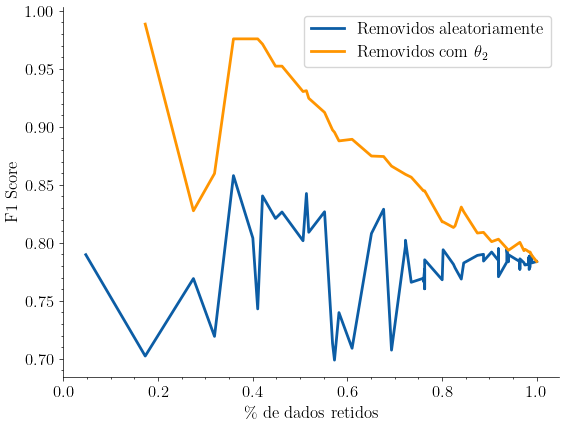

In [38]:
plt.plot(1-removed_mean_random, metric_mean_random)
plt.plot(1-removed_mean, metric_mean)
plt.xlabel('\% de dados retidos')
plt.ylabel('F1 Score')
plt.legend(['Removidos aleatoriamente', 'Removidos com $\\theta_2$'], loc='upper right')
plt.savefig(f'random_remove_theta2_{model}.pdf', 
                    dpi=300, 
                    bbox_inches='tight')


### $\theta_3$

In [39]:
removed_correct_data_theta_3_folds = []
removed_incorrect_data_theta_3_folds = []
remove_total_data_theta_3_folds = []

accuracy_3_folds = []
f1_3_folds = []
precision_3_folds  = []
sensitivity_3_folds = []
specificity_3_folds = []
auc_3_folds = []

ranged = np.linspace(0,dataframe_original['stds'].max(),100)

for theta_3 in ranged:

    removed_correct_data_theta_3 = np.zeros(len(results_originais.keys()))
    removed_incorrect_data_theta_3 = np.zeros(len(results_originais.keys()))
    remove_total_data_theta_3 = np.zeros(len(results_originais.keys()))

    accuracy_theta_3 = np.zeros(len(results_originais.keys()))
    f1_theta_3 = np.zeros(len(results_originais.keys()))
    precision_theta_3   = np.zeros(len(results_originais.keys()))
    sensitivity_theta_3 = np.zeros(len(results_originais.keys()))
    specificity_theta_3 = np.zeros(len(results_originais.keys()))
    auc_theta_3 = np.zeros(len(results_originais.keys()))

    for fold in range(10):

        fold_results = dataframe_calib[dataframe_calib['fold']==fold]
        
        fold_results_original = dataframe_original[dataframe_original['fold']==fold]

        preds_certain_mask = fold_results_original['stds'] <= theta_3

        preds_theta_3_aux = np.empty(fold_results_original['probs'].shape)
        preds_theta_3_aux.fill(np.nan)
        preds_theta_3_aux[preds_certain_mask] = fold_results_original['preds'][preds_certain_mask]

        index_remove = np.isnan(preds_theta_3_aux)

        total_corrects = fold_results_original['corrects']

        removed_data = total_corrects[index_remove]

        removed_correct_data_theta_3[fold] = removed_data.sum() / total_corrects.sum()
        removed_incorrect_data_theta_3[fold] = (~removed_data).sum() / (~total_corrects).sum()
        remove_total_data_theta_3[fold] = index_remove.sum() / len(index_remove)

        preds = fold_results_original['preds'][~index_remove]
        probs = fold_results_original['probs'][~index_remove]
        labels = fold_results_original['labels'][~index_remove]

        if len(preds) > 0:
            try:
                metrics = validation_metrics(preds, probs, labels)
                accuracy_theta_3[fold] = metrics['Accuracy']
                f1_theta_3[fold] = metrics['F1 Score']
                precision_theta_3[fold] = metrics['Precision']
                sensitivity_theta_3[fold] = metrics['Sensitivity']
                specificity_theta_3[fold] = metrics['Specificity']
                auc_theta_3[fold] = metrics['AUC']
            except ValueError:
                accuracy_theta_3[fold] = np.nan
                f1_theta_3[fold] = np.nan
                precision_theta_3[fold] = np.nan
                sensitivity_theta_3[fold] = np.nan
                specificity_theta_3[fold] = np.nan
                auc_theta_3[fold] = np.nan

        else:
            accuracy_theta_3[fold] = np.nan
            f1_theta_3[fold] = np.nan
            precision_theta_3[fold] = np.nan
            sensitivity_theta_3[fold] = np.nan
            specificity_theta_3[fold] = np.nan
            auc_theta_3[fold] = np.nan

    accuracy_theta_3[np.isnan(accuracy_theta_3)] = np.nanmean(accuracy_theta_3)
    f1_theta_3[np.isnan(f1_theta_3)] = np.nanmean(f1_theta_3)
    precision_theta_3[np.isnan(precision_theta_3)] = np.nanmean(precision_theta_3)
    sensitivity_theta_3[np.isnan(sensitivity_theta_3)] = np.nanmean(sensitivity_theta_3)
    specificity_theta_3[np.isnan(specificity_theta_3)] = np.nanmean(specificity_theta_3)
    auc_theta_3[np.isnan(auc_theta_3)] = np.nanmean(auc_theta_3)

    removed_correct_data_theta_3_folds.append(removed_correct_data_theta_3)
    removed_incorrect_data_theta_3_folds.append(removed_incorrect_data_theta_3)
    remove_total_data_theta_3_folds.append(remove_total_data_theta_3)

    accuracy_3_folds.append(accuracy_theta_3)
    f1_3_folds.append(f1_theta_3)
    precision_3_folds.append(precision_theta_3)
    sensitivity_3_folds.append(sensitivity_theta_3)
    specificity_3_folds.append(specificity_theta_3)
    auc_3_folds.append(auc_theta_3)


removed_correct_data_theta_3_folds = np.array(removed_correct_data_theta_3_folds)
removed_incorrect_data_theta_3_folds = np.array(removed_incorrect_data_theta_3_folds)
remove_total_data_theta_3_folds = np.array(remove_total_data_theta_3_folds)

accuracy_3_folds = np.array(accuracy_3_folds)
f1_3_folds = np.array(f1_3_folds)
precision_3_folds = np.array(precision_3_folds)
sensitivity_3_folds = np.array(sensitivity_3_folds)
specificity_3_folds = np.array(specificity_3_folds)
auc_3_folds = np.array(auc_3_folds)
    
    

C:\Users\leonardo\AppData\Local\Temp\ipykernel_13976\2951680663.py:78: RuntimeWarning: Mean of empty slice
  accuracy_theta_3[np.isnan(accuracy_theta_3)] = np.nanmean(accuracy_theta_3)
C:\Users\leonardo\AppData\Local\Temp\ipykernel_13976\2951680663.py:79: RuntimeWarning: Mean of empty slice
  f1_theta_3[np.isnan(f1_theta_3)] = np.nanmean(f1_theta_3)
C:\Users\leonardo\AppData\Local\Temp\ipykernel_13976\2951680663.py:80: RuntimeWarning: Mean of empty slice
  precision_theta_3[np.isnan(precision_theta_3)] = np.nanmean(precision_theta_3)
C:\Users\leonardo\AppData\Local\Temp\ipykernel_13976\2951680663.py:81: RuntimeWarning: Mean of empty slice
  sensitivity_theta_3[np.isnan(sensitivity_theta_3)] = np.nanmean(sensitivity_theta_3)
C:\Users\leonardo\AppData\Local\Temp\ipykernel_13976\2951680663.py:82: RuntimeWarning: Mean of empty slice
  specificity_theta_3[np.isnan(specificity_theta_3)] = np.nanmean(specificity_theta_3)
C:\Users\leonardo\AppData\Local\Temp\ipykernel_13976\2951680663.py:83: R

In [40]:
removed_mean = remove_total_data_theta_3_folds.mean(axis=1)
removed_std = remove_total_data_theta_3_folds.std(axis=1)

metric_mean = f1_3_folds.mean(axis=1)
metric_std = f1_3_folds.std(axis=1)


In [41]:
accuracy_random_folds = []
f1_random_folds = []
precision_random_folds  = []
sensitivity_random_folds = []
specificity_random_folds = []
auc_random_folds = []

for t in range(len(remove_total_data_theta_3_folds)):

    accuracy_random = np.zeros(len(results_originais.keys()))
    f1_random = np.zeros(len(results_originais.keys()))
    precision_random   = np.zeros(len(results_originais.keys()))
    sensitivity_random = np.zeros(len(results_originais.keys()))
    specificity_random = np.zeros(len(results_originais.keys()))
    auc_random = np.zeros(len(results_originais.keys()))

    for fold, removed in enumerate(remove_total_data_theta_3_folds[t]):

        samples_folds = dataframe_original[dataframe_original['fold']==fold]

        total_removed_samples = int(removed * len(samples_folds))

        retained_data = samples_folds.sample(len(samples_folds)-total_removed_samples)

        preds = retained_data['preds']
        probs = retained_data['probs']
        labels = retained_data['labels']

        if len(retained_data) > 0:
            try:
                metrics = validation_metrics(preds, probs, labels)
                accuracy_random[fold] = metrics['Accuracy']
                f1_random[fold] = metrics['F1 Score']
                precision_random[fold] = metrics['Precision']
                sensitivity_random[fold] = metrics['Sensitivity']
                specificity_random[fold] = metrics['Specificity']
                auc_random[fold] = metrics['AUC']
            except ValueError:
                accuracy_random[fold] = np.nan
                f1_random[fold] = np.nan
                precision_random[fold] = np.nan
                sensitivity_random[fold] = np.nan
                specificity_random[fold] = np.nan
                auc_random[fold] = np.nan

        else:
            accuracy_random[fold] = np.nan
            f1_random[fold] = np.nan
            precision_random[fold] = np.nan
            sensitivity_random[fold] = np.nan
            specificity_random[fold] = np.nan
            auc_random[fold] = np.nan

    accuracy_random[np.isnan(accuracy_random)] = np.nanmean(accuracy_random)
    f1_random[np.isnan(f1_random)] = np.nanmean(f1_random)
    precision_random[np.isnan(precision_random)] = np.nanmean(precision_random)
    sensitivity_random[np.isnan(sensitivity_random)] = np.nanmean(sensitivity_random)
    specificity_random[np.isnan(specificity_random)] = np.nanmean(specificity_random)
    auc_random[np.isnan(auc_random)] = np.nanmean(auc_random)

    accuracy_random_folds.append(accuracy_random)
    f1_random_folds.append(f1_random)
    precision_random_folds.append(precision_random)
    sensitivity_random_folds.append(sensitivity_random)
    specificity_random_folds.append(specificity_random)
    auc_random_folds.append(auc_random)

accuracy_random_folds = np.array(accuracy_random_folds)
f1_random_folds = np.array(f1_random_folds)
precision_random_folds = np.array(precision_random_folds)
sensitivity_random_folds = np.array(sensitivity_random_folds)
specificity_random_folds = np.array(specificity_random_folds)
auc_random_folds = np.array(auc_random_folds)


C:\Users\leonardo\AppData\Local\Temp\ipykernel_13976\3367281213.py:54: RuntimeWarning: Mean of empty slice
  accuracy_random[np.isnan(accuracy_random)] = np.nanmean(accuracy_random)
C:\Users\leonardo\AppData\Local\Temp\ipykernel_13976\3367281213.py:55: RuntimeWarning: Mean of empty slice
  f1_random[np.isnan(f1_random)] = np.nanmean(f1_random)
C:\Users\leonardo\AppData\Local\Temp\ipykernel_13976\3367281213.py:56: RuntimeWarning: Mean of empty slice
  precision_random[np.isnan(precision_random)] = np.nanmean(precision_random)
C:\Users\leonardo\AppData\Local\Temp\ipykernel_13976\3367281213.py:57: RuntimeWarning: Mean of empty slice
  sensitivity_random[np.isnan(sensitivity_random)] = np.nanmean(sensitivity_random)
C:\Users\leonardo\AppData\Local\Temp\ipykernel_13976\3367281213.py:58: RuntimeWarning: Mean of empty slice
  specificity_random[np.isnan(specificity_random)] = np.nanmean(specificity_random)
C:\Users\leonardo\AppData\Local\Temp\ipykernel_13976\3367281213.py:59: RuntimeWarning: 

In [42]:
removed_mean_random = remove_total_data_theta_3_folds.mean(axis=1)
removed_std_random = remove_total_data_theta_3_folds.std(axis=1)

metric_mean_random = f1_random_folds.mean(axis=1)
metric_std_random = f1_random_folds.std(axis=1)

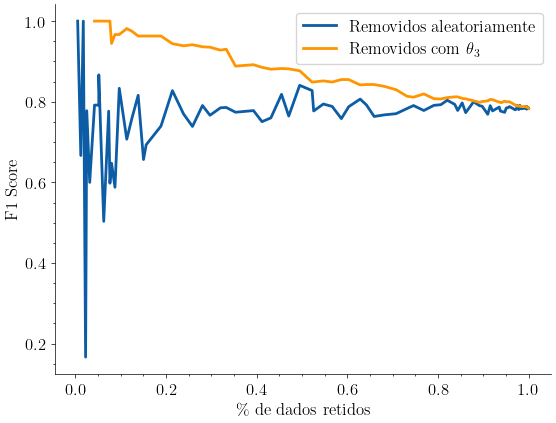

In [43]:
plt.plot(1-removed_mean_random, metric_mean_random)
#plt.fill_between(1-removed_mean_random, metric_mean_random+metric_std_random, metric_mean_random-metric_std_random, alpha=0.3)
plt.plot(1-removed_mean, metric_mean)
#plt.fill_between(1-removed_mean_random, metric_mean+metric_std, metric_mean-metric_std, alpha=0.3)
plt.xlabel('\% de dados retidos')
plt.ylabel('F1 Score')
plt.legend(['Removidos aleatoriamente', 'Removidos com $\\theta_3$'], loc='upper right')
plt.savefig(f'random_remove_theta3_{model}.pdf', 
                    dpi=300, 
                    bbox_inches='tight')


## Vizu

In [44]:
dataframe_original['theta_3'].mean()

0.04708412

c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\leonardo\AppData\Local\Programs\Python\Python31

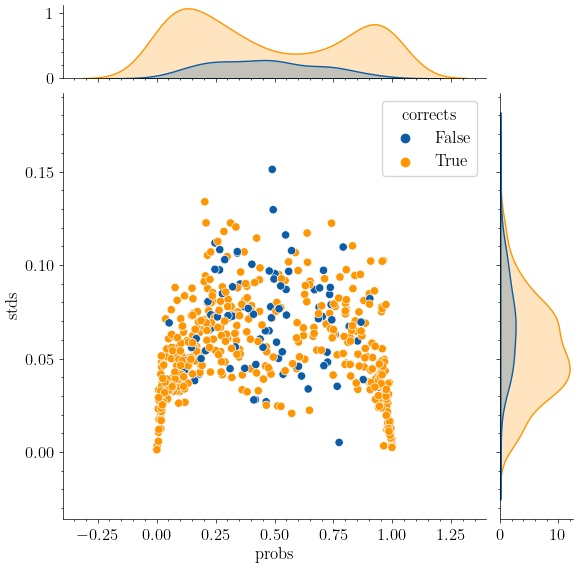

In [45]:
g = sns.jointplot(x="probs", y="stds", data=dataframe_original, hue='corrects',marginal_ticks=True, )

NameError: name 'predicted_values' is not defined

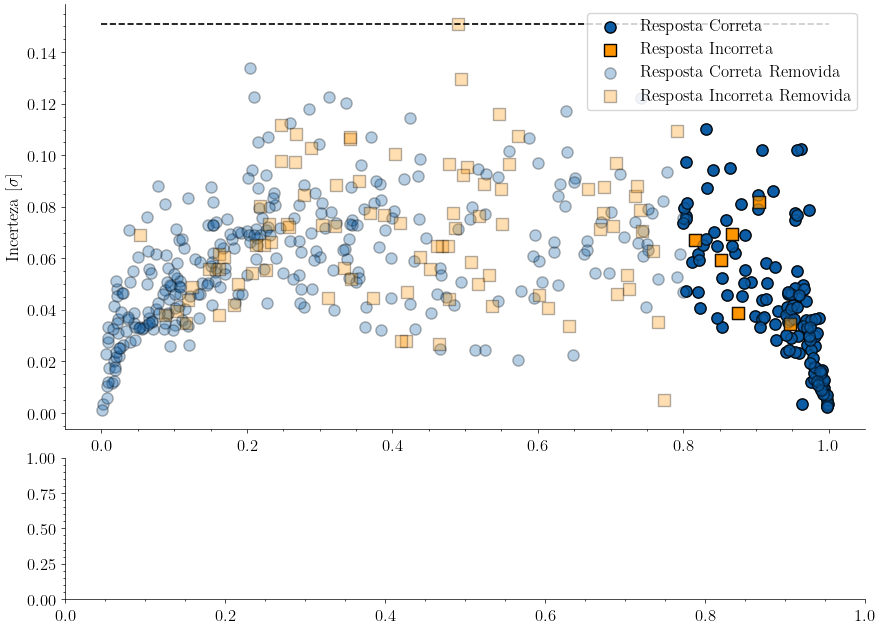

In [46]:
alpha = 0.3
cor_correta = '#0C5DA5'
cor_incorreta = '#FF9500'

theta_2_upper = 0.8
theta_2_lower = 0.0

fig = plt.figure(figsize=(10,7))

gs = fig.add_gridspec(2, 1,  height_ratios=(3, 1), left=0.1, right=0.9, bottom=0.05, top=0.9, hspace=0.1)

ax_scatter = fig.add_subplot(gs[0])
ax_bar= fig.add_subplot(gs[1])


dataframe_corrects = dataframe_original[(dataframe_original['corrects']==True)]
dataframe_incorrects = dataframe_original[(dataframe_original['corrects']==False)]



dataframe_corrects_precise_certain = dataframe_corrects[(dataframe_corrects['stds']<=theta_3) & ((dataframe_corrects['probs']>=theta_2_upper) | (dataframe_corrects['probs']<=theta_2_lower))]
dataframe_incorrects_precise_certain = dataframe_incorrects[(dataframe_incorrects['stds']<=theta_3) & ((dataframe_incorrects['probs']>=theta_2_upper) | (dataframe_incorrects['probs']<=theta_2_lower))]

dataframe_corrects_imprecise_incertain = dataframe_corrects[(dataframe_corrects['stds']>theta_3) & ((dataframe_corrects['probs']<=theta_2_upper) | (dataframe_corrects['probs']>=theta_2_lower))]
dataframe_incorrects_imprecise_incertain = dataframe_incorrects[(dataframe_incorrects['stds']>theta_3) & ((dataframe_incorrects['probs']<=theta_2_upper) | (dataframe_incorrects['probs']>=theta_2_lower))]

dataframe_corrects_precise_incertain = dataframe_corrects[(dataframe_corrects['stds']>theta_3) & ((dataframe_corrects['probs']>=theta_2_upper) | (dataframe_corrects['probs']<=theta_2_lower))]
dataframe_incorrects_precise_incertain = dataframe_incorrects[(dataframe_incorrects['stds']>theta_3) & ((dataframe_incorrects['probs']>=theta_2_upper) | (dataframe_incorrects['probs']<=theta_2_lower))]

dataframe_corrects_imprecise_certain = dataframe_corrects[(dataframe_corrects['stds']<=theta_3) & ((dataframe_corrects['probs']<=theta_2_upper) | (dataframe_corrects['probs']>=theta_2_lower))]
dataframe_incorrects_imprecise_certain = dataframe_incorrects[(dataframe_incorrects['stds']<=theta_3) & ((dataframe_incorrects['probs']<=theta_2_upper) | (dataframe_incorrects['probs']>=theta_2_lower))]


ax_scatter.scatter(dataframe_corrects_precise_certain['probs'], dataframe_corrects_precise_certain['stds'], s=65, edgecolors='k', color=cor_correta, label='Resposta Correta')
ax_scatter.scatter(dataframe_incorrects_precise_certain['probs'], dataframe_incorrects_precise_certain['stds'], s=65, edgecolors='k', marker='s', color=cor_incorreta, label='Resposta Incorreta')

ax_scatter.scatter(dataframe_corrects_imprecise_incertain['probs'], dataframe_corrects_imprecise_incertain['stds'], s=65, edgecolors='k', color=cor_correta, alpha=alpha, label='Resposta Correta Removida')
ax_scatter.scatter(dataframe_incorrects_imprecise_incertain['probs'], dataframe_incorrects_imprecise_incertain['stds'], s=65, edgecolors='k', marker='s', color=cor_incorreta, alpha=alpha, label='Resposta Incorreta Removida')

ax_scatter.scatter(dataframe_corrects_precise_incertain['probs'], dataframe_corrects_precise_incertain['stds'], s=65, edgecolors='k', color=cor_correta, alpha=alpha)
ax_scatter.scatter(dataframe_incorrects_precise_incertain['probs'], dataframe_incorrects_precise_incertain['stds'], s=65, edgecolors='k', marker='s', color=cor_incorreta, alpha=alpha)

ax_scatter.scatter(dataframe_corrects_imprecise_certain['probs'], dataframe_corrects_imprecise_certain['stds'], s=65, edgecolors='k', color=cor_correta, alpha=alpha)
ax_scatter.scatter(dataframe_incorrects_imprecise_certain['probs'], dataframe_incorrects_imprecise_certain['stds'], s=65, edgecolors='k', marker='s', color=cor_incorreta, alpha=alpha)


#ax_scatter.fill_between([0,1], threshs_stds.mean(),0.28, alpha=0.2, edgecolor='None', color='red')
#ax_scatter.fill_between([0.1,0.7], [0.075],[threshs_stds.mean()], alpha=0.2, edgecolor='None', color='orange')

ax_scatter.hlines(theta_3, 0, 1, linestyles="--", colors='#000', linewidth=1.2)
ax_scatter.set_ylabel('Incerteza [$\sigma$]')
ax_scatter.legend()

ax_bar.bar(x=bins[:-1], height=predicted_values, width=0.1, edgecolor='k', align='edge', color='#8c8c8c')
ax_bar.bar(x=bins[indexes_thresh], height=predicted_values[indexes_thresh], width=0.1, edgecolor='k', align='edge', color='#0C5DA5')
#plt.bar(x=bins[:-1], height=predicted_values_above, width=0.1, edgecolor='k', align='edge')
ax_bar.set_xlim([-0.05,1.05])
ax_bar.set_ylim([0.4,1.05])
ax_bar.hlines(theta_2, 0, 1, linestyles="--", colors='#000', linewidth=1.2)
ax_bar.set_xlabel('Probabilidade Prevista')
ax_bar.set_ylabel('Precisão')
plt.savefig(f"respostas_removidas.png", dpi=150, bbox_inches='tight')